In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from preprocessing import load_file_data, filter_eeg_data
from dataset import EEGDataset, epoch_data, k_fold_validation_split
from snn import SNN, SpikingModel, train_model, test_model

# Focus Data Preparation

Creating RawArray with float64 data, n_channels=8, n_times=7493
    Range : 0 ... 7492 =      0.000 ...    29.968 secs
Ready.
Using matplotlib as 2D backend.


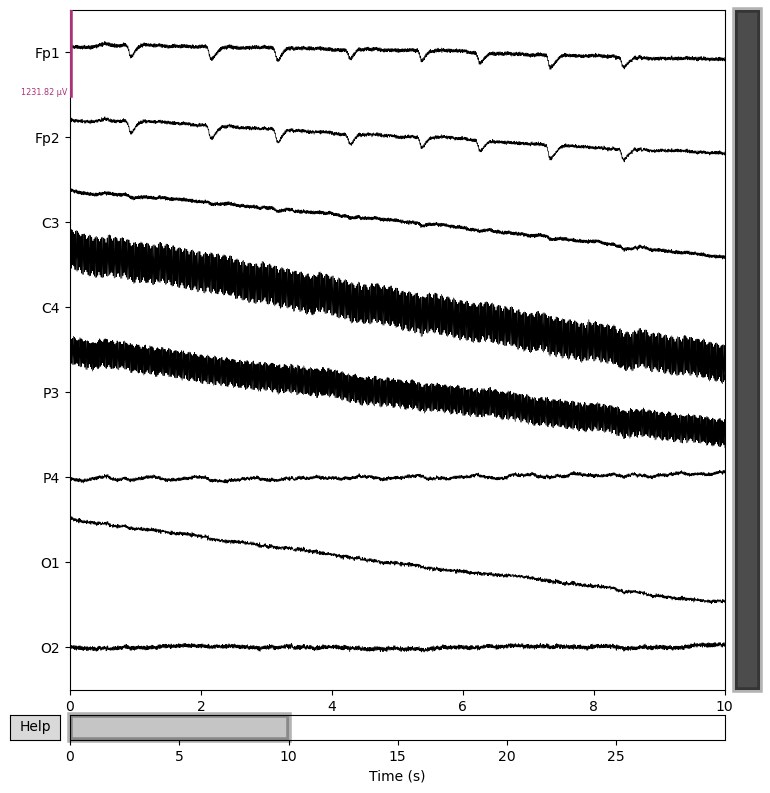

In [2]:
raw_focus = load_file_data("OpenBCISession_steve_focus1/OpenBCI-RAW.csv")
raw_focus.plot(n_channels=8, scalings='auto');

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


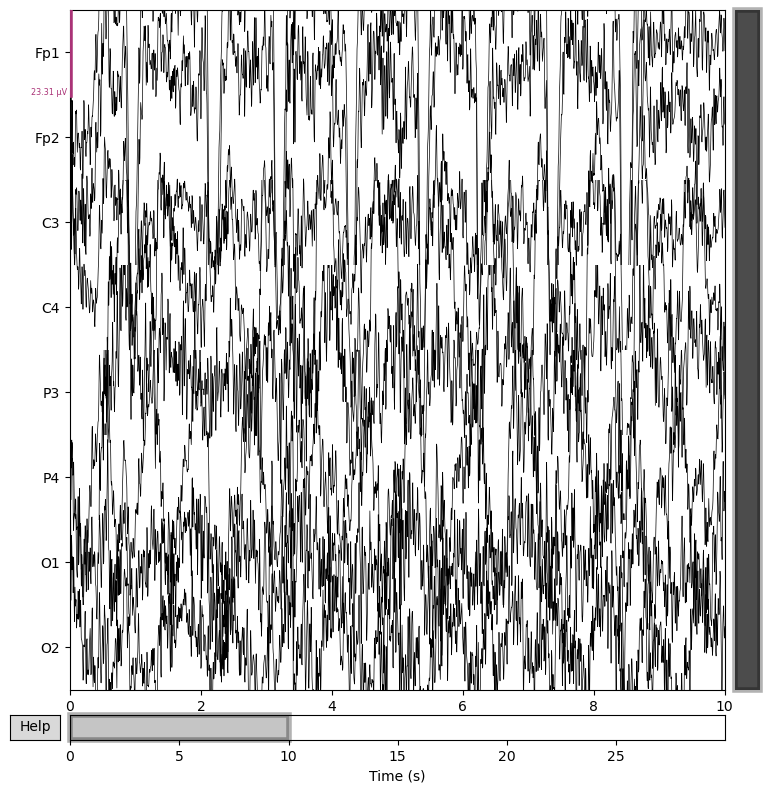

In [3]:
# Apply notch filter to remove 60Hz noise
filtered = filter_eeg_data(raw_focus)
filtered.plot(n_channels=8, scalings='auto');

In [4]:
# Epoch data into 0.5 second windows
epochs = epoch_data(filtered, time_window=0.5, overlap=0)
print(epochs.get_data().shape)
print(epochs.get_data()[0].shape)

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 126 original time points ...
0 bad epochs dropped
(59, 8, 126)
(8, 126)


In [5]:
psd = []

for i in range(len(epochs)):
    # Compute the power spectral density of each channel
    psd += [epochs[i].compute_psd(method='multitaper', fmin=1, fmax=50)]
    # # Plot the power spectral density
    # psd[i].plot(picks=[0, 1, 2, 3, 4, 5, 6, 7], average=False);
    # plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [6]:
deltas = []
thetas = []
alphas = []
betas = []
gammas = []

for i in range(len(epochs)):
    # Get delta, theta, alpha, beta, and gamma bands
    deltas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=1, fmax=4).mean()]
    thetas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=4, fmax=8).mean()]
    alphas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=8, fmax=13).mean()]
    betas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=13, fmax=30).mean()]
    gammas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=30, fmax=50).mean()]

print(deltas)
print(thetas)
print(alphas)
print(betas)
print(gammas)

[2.2584154414416635e-08, 2.904822208977827e-08, 3.757934276056056e-09, 1.8538349383524244e-09, 3.4720343297919576e-08, 2.061507398957376e-09, 3.0772362499664764e-08, 4.3793799938977855e-09, 1.7379779034063493e-08, 2.5466654747940486e-09, 1.9294088651905106e-08, 1.850587703159669e-09, 2.472149451987587e-08, 3.0215458529107606e-09, 3.7692993794608913e-08, 2.5162183178319515e-09, 2.2952891054332884e-08, 8.759274975755777e-09, 2.272922949019581e-09, 1.7074513519483821e-09, 2.262298780933449e-08, 2.739785668001621e-09, 3.0002040772392893e-09, 4.355003988254794e-09, 2.6479940032550117e-09, 2.5152476888877757e-08, 3.796450867445675e-09, 1.3585422805259164e-09, 1.3877727858995607e-09, 2.8164572544239805e-08, 1.7298338340327726e-09, 2.155671478203995e-09, 1.8699602664235555e-08, 2.4274939569316307e-09, 1.2398614837853086e-09, 1.644810918623055e-08, 4.020140533786555e-09, 3.376773888109656e-09, 1.9080383753457245e-09, 1.1832219935946767e-09, 3.122255977910186e-08, 1.516340298321662e-09, 1.109159

In [7]:
# Make new dataframe with the delta, theta, alpha, beta, and gamma bands
focus_df = pd.DataFrame({'delta': deltas, 'theta': thetas, 'alpha': alphas, 'beta': betas, 'gamma': gammas})

# Add new column with label = 'Focus'
focus_df['focus'] = 1

focus_df

,delta,theta,alpha,beta,gamma,focus
0,2.258415e-08,1.437863e-08,1.442529e-09,3.754654e-10,2.836846e-10,1
1,2.904822e-08,1.802272e-08,4.712616e-09,3.175312e-10,1.001361e-10,1
2,3.757934e-09,2.306478e-09,7.879653e-10,1.881961e-10,7.054457e-11,1
3,1.853835e-09,1.225215e-09,2.344179e-10,1.170465e-10,8.609723e-11,1
4,3.472034e-08,1.906999e-08,5.341847e-09,2.877331e-10,8.807635e-11,1
5,2.061507e-09,1.376112e-09,5.647213e-10,2.033192e-10,8.226731e-11,1
6,3.077236e-08,1.708184e-08,6.267449e-09,3.658023e-10,1.476890e-10,1
7,4.379380e-09,2.730677e-09,6.404461e-10,2.483762e-10,1.127686e-10,1
8,1.737978e-08,9.865440e-09,3.770857e-09,2.522140e-10,8.504376e-11,1
9,2.546665e-09,1.585413e-09,5.547035e-10,1.764364e-10,1.385853e-10,1


In [8]:
# # Make new data frame with 8 channels of data
# focus_df = pd.DataFrame(epochs.get_data()[0].transpose(), columns=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'])

# # Add new column with label = 1 for focus
# focus_df['focus'] = 1

# display(focus_df)

# No Focus Data Preparation

Creating RawArray with float64 data, n_channels=8, n_times=7414
    Range : 0 ... 7413 =      0.000 ...    29.652 secs
Ready.


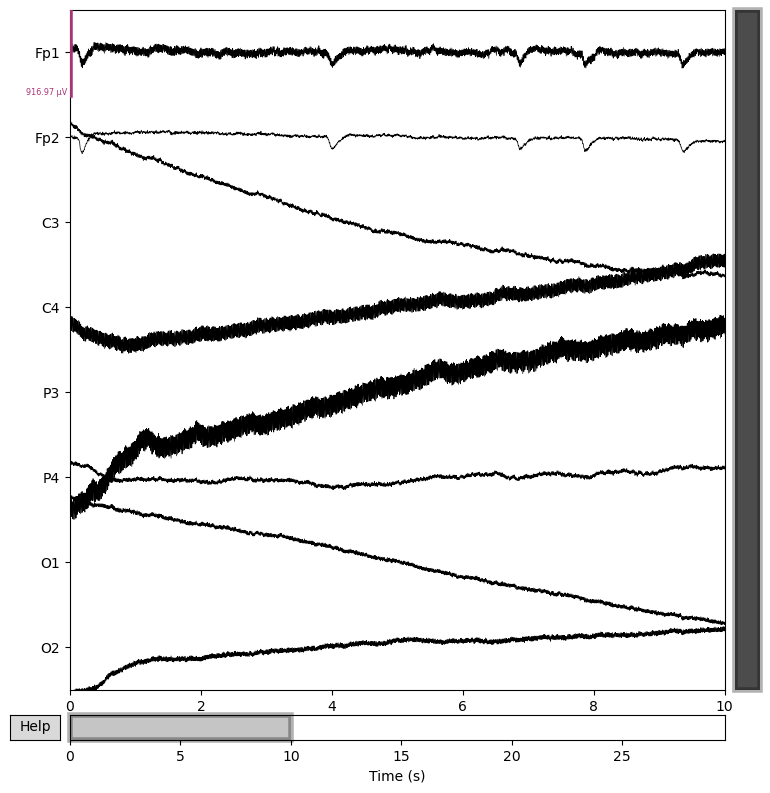

In [9]:
raw_focus = load_file_data("OpenBCISession_steve_nofocus1/OpenBCI-RAW.csv")
raw_focus.plot(n_channels=8, scalings='auto');

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


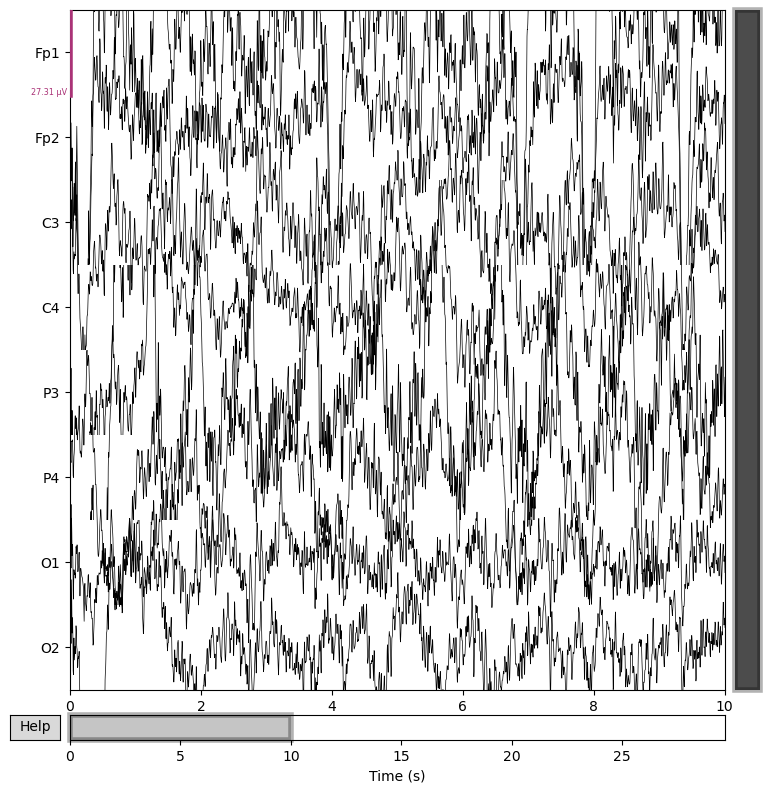

In [10]:
# Apply notch filter to remove 60Hz noise
filtered = filter_eeg_data(raw_focus)
filtered.plot(n_channels=8, scalings='auto');

In [11]:
# Epoch data into 1 second windows
epochs = epoch_data(filtered, time_window=0.5, overlap=0)
print(epochs.get_data().shape)
print(epochs.get_data()[0].shape)

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 126 original time points ...
0 bad epochs dropped
(59, 8, 126)
(8, 126)


In [12]:
psd = []

for i in range(len(epochs)):
    # Compute the power spectral density of each channel
    psd += [epochs[i].compute_psd(method='multitaper', fmin=1, fmax=50)]
    # Plot the power spectral density
    # psd[i].plot(picks=[0, 1, 2, 3, 4, 5, 6, 7], average=False);
    # plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [13]:
deltas = []
thetas = []
alphas = []
betas = []
gammas = []

for i in range(len(epochs)):
    # Get delta, theta, alpha, beta, and gamma bands
    deltas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=1, fmax=4).mean()]
    thetas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=4, fmax=8).mean()]
    alphas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=8, fmax=13).mean()]
    betas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=13, fmax=30).mean()]
    gammas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=30, fmax=50).mean()]

print(deltas)
print(thetas)
print(alphas)
print(betas)
print(gammas)

[3.979081656027446e-08, 7.633511490022469e-09, 2.3088051884706555e-08, 5.886305679506332e-09, 2.2043444315011065e-09, 3.378446769383367e-09, 1.020360087960264e-09, 6.56846720040679e-09, 1.3666658429182521e-08, 2.763860184662393e-09, 2.7433008280655658e-09, 8.96206979396643e-09, 3.216161411762607e-09, 1.9492831588073753e-08, 3.7350486106292856e-09, 2.2694747887571535e-08, 2.4007929642392927e-09, 2.7553705929230587e-09, 1.7418475675364542e-08, 1.583880286980912e-09, 2.4030325421079278e-09, 2.1036863272693583e-09, 1.7467939816175006e-08, 1.8525325658273022e-09, 2.4544497197198487e-09, 1.3501528926926228e-09, 3.6535154579680007e-09, 2.300285028208361e-09, 1.6522385449226767e-08, 1.5070926585917307e-09, 4.691019396022418e-09, 1.6238414048370616e-09, 1.5294112774104053e-08, 1.6766240178563938e-09, 2.0789787367822583e-09, 1.0456408454833236e-08, 2.1029028966213456e-09, 1.6142359414449812e-09, 1.6176431283989947e-09, 1.5247218869977674e-08, 1.65406647095147e-09, 3.1433869497973504e-09, 2.18347

In [14]:
# Make new dataframe with the delta, theta, alpha, beta, and gamma bands
nofocus_df = pd.DataFrame({'delta': deltas, 'theta': thetas, 'alpha': alphas, 'beta': betas, 'gamma': gammas})

# Add new column with label = 'No Focus'
nofocus_df['focus'] = 0

nofocus_df

,delta,theta,alpha,beta,gamma,focus
0,3.979082e-08,2.175225e-08,5.277086e-09,3.402633e-10,1.079083e-10,0
1,7.633511e-09,4.752723e-09,1.127247e-09,2.551859e-10,7.898043e-11,0
2,2.308805e-08,1.363792e-08,7.295858e-10,2.720715e-10,8.606816e-11,0
3,5.886306e-09,3.828273e-09,7.688694e-10,1.974724e-10,7.763387e-11,0
4,2.204344e-09,1.412086e-09,5.446058e-10,1.777493e-10,4.735767e-11,0
5,3.378447e-09,2.087098e-09,6.381411e-10,1.999420e-10,8.948380e-11,0
6,1.020360e-09,8.148609e-10,4.759499e-10,2.088264e-10,6.815673e-11,0
7,6.568467e-09,4.450298e-09,1.421385e-09,3.451162e-10,9.275259e-11,0
8,1.366666e-08,7.789026e-09,8.509356e-10,2.410528e-10,6.252095e-11,0
9,2.763860e-09,1.812075e-09,6.071425e-10,2.655019e-10,7.591692e-11,0


In [15]:
# # Make new data frame with 8 channels of data
# nofocus_df = pd.DataFrame(epochs.get_data()[0].transpose(), columns=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'])

# # Add new columns with label = 0 for no focus
# nofocus_df['focus'] = 0

# display(nofocus_df)

# Create Dataset and Dataloaders

In [16]:
from sklearn.model_selection import train_test_split

train_focus, test_focus = train_test_split(focus_df, test_size=0.2, shuffle=False)

train_nofocus, test_nofocus = train_test_split(nofocus_df, test_size=0.2, shuffle=False)

# Concatenate the focus and no focus dataframes
train_df = pd.concat([train_focus, train_nofocus])
test_df = pd.concat([test_focus, test_nofocus])

display(train_df.shape)
display(test_df.shape)
display(train_df)
display(test_df)

(94, 6)

(24, 6)

,delta,theta,alpha,beta,gamma,focus
0,2.258415e-08,1.437863e-08,1.442529e-09,3.754654e-10,2.836846e-10,1
1,2.904822e-08,1.802272e-08,4.712616e-09,3.175312e-10,1.001361e-10,1
2,3.757934e-09,2.306478e-09,7.879653e-10,1.881961e-10,7.054457e-11,1
3,1.853835e-09,1.225215e-09,2.344179e-10,1.170465e-10,8.609723e-11,1
4,3.472034e-08,1.906999e-08,5.341847e-09,2.877331e-10,8.807635e-11,1
...,...,...,...,...,...,...
42,2.183472e-09,1.565135e-09,6.245268e-10,1.950897e-10,5.802781e-11,0
43,3.958484e-09,2.464488e-09,7.996655e-10,2.651642e-10,4.596447e-11,0
44,1.427340e-09,1.030354e-09,5.341113e-10,1.855107e-10,4.242134e-11,0
45,3.252339e-09,2.161478e-09,6.274266e-10,2.366305e-10,6.674333e-11,0


,delta,theta,alpha,beta,gamma,focus
47,1.977618e-09,1.275673e-09,4.038170e-10,1.541974e-10,9.065038e-11,1
48,1.558749e-09,1.058115e-09,3.084753e-10,1.136253e-10,6.373038e-11,1
49,2.893947e-09,1.872130e-09,4.435629e-10,1.815667e-10,1.001742e-10,1
50,2.542579e-08,1.344862e-08,3.346580e-09,2.379462e-10,9.128736e-11,1
51,5.723204e-09,3.205051e-09,7.638012e-10,2.112731e-10,1.176142e-10,1
52,3.424861e-08,1.843763e-08,3.623863e-09,2.395818e-10,9.182125e-11,1
53,3.162966e-09,2.134071e-09,5.356270e-10,3.172814e-10,8.635887e-11,1
54,3.890209e-09,2.550495e-09,7.607904e-10,2.025530e-10,9.880955e-11,1
55,3.074237e-08,1.859428e-08,1.989095e-09,2.440907e-10,1.020342e-10,1
56,2.342178e-08,1.291539e-08,4.521232e-09,2.985253e-10,9.704637e-11,1


In [17]:
# Normalize the data
# train_df[:, :-1] = (train_df[:, :-1] - train_df[:, :-1].mean()) / train_df[:, :-1].std()
# test_df[:, :-1] = (test_df[:, :-1] - test_df[:, :-1].mean()) / test_df[:, :-1].std()

# Normalize all columns except the last
train_df.iloc[:, :-1] = (train_df.iloc[:, :-1] - train_df.iloc[:, :-1].mean()) / train_df.iloc[:, :-1].std()
test_df.iloc[:, :-1] = (test_df.iloc[:, :-1] - test_df.iloc[:, :-1].mean()) / test_df.iloc[:, :-1].std()

display(train_df)
display(test_df)

,delta,theta,alpha,beta,gamma,focus
0,1.205107,1.431105,0.034987,2.194868,5.736095,1
1,1.791875,2.019993,2.277816,1.236439,0.394013,1
2,-0.503817,-0.519763,-0.413953,-0.903204,-0.467233,1
3,-0.676660,-0.694496,-0.793610,-2.080260,-0.014581,1
4,2.306754,2.189233,2.709382,0.743476,0.043020,1
...,...,...,...,...,...,...
42,-0.646737,-0.639565,-0.526049,-0.789160,-0.831527,0
43,-0.485613,-0.494229,-0.405929,0.370111,-1.182624,0
44,-0.715374,-0.725986,-0.588062,-0.947630,-1.285745,0
45,-0.549712,-0.543196,-0.524061,-0.101934,-0.577866,0


,delta,theta,alpha,beta,gamma,focus
47,-0.569141,-0.575802,-0.645401,-1.187874,0.702602,1
48,-0.603634,-0.606967,-0.713349,-1.630405,-0.553575,1
49,-0.493683,-0.490361,-0.617075,-0.889349,1.147014,1
50,1.361771,1.167941,1.451848,-0.274403,0.732326,1
51,-0.260699,-0.299424,-0.388847,-0.565334,1.960824,1
52,2.088313,1.882605,1.649462,-0.256563,0.757239,1
53,-0.471530,-0.452839,-0.551462,0.590928,0.502346,1
54,-0.411643,-0.393187,-0.390993,-0.660447,1.083336,1
55,1.799581,1.905044,0.484395,-0.207383,1.233811,1
56,1.196744,1.091558,2.288999,0.386350,1.001060,1


In [42]:
import xgboost as xgb

train_data = train_df.iloc[:, :-1].to_numpy()
train_labels = train_df.iloc[:, -1].to_numpy()
test_data = test_df.iloc[:, :-1].to_numpy()
test_labels = test_df.iloc[:, -1].to_numpy()

clf = xgb.XGBClassifier()
clf.fit(train_data, train_labels)

test_predictions = clf.predict(test_data)
print(test_predictions)

# get accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, test_predictions)
print(accuracy)

data = np.array([[-0.360076, -0.357710, -0.454732, -0.058658, -0.469944]])
print(data)
prediction = clf.predict(data)
print(prediction)

[1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0]
0.9166666666666666
[[-0.360076 -0.35771  -0.454732 -0.058658 -0.469944]]
[0]


In [ ]:
clf.save_model('xgb_model.json')

# Train and Test ML model